In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../../")

import numpy as np

# %matplotlib widget

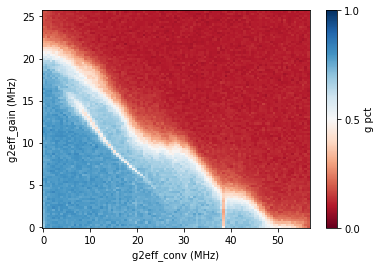

In [2]:
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from weyl_decompose import RootiSwapWeylDecomposition as decomposer
from qiskit.transpiler.passes import Collect2qBlocks, ConsolidateBlocks, Unroll3qOrMore, Optimize1qGates
from src.utils.custom_gates import RiSwapGate
from qiskit.circuit.library import CXGate
from qiskit.converters import circuit_to_dag
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.quantum_info import Operator
from src.basis import MixedOrderBasisCircuitTemplate
from src.utils.polytope_wrap import monodromy_range_from_target
from src.scripts.gate_exploration.bgatev2script import get_group_name, cost_scaling, pick_winner, recursive_sibling_check
from qiskit.transpiler.basepasses import AnalysisPass
from qiskit.transpiler.passes import CountOps
from qiskit.dagcircuit import DAGOpNode, DAGCircuit
from qiskit.transpiler import PassManager
from itertools import product

In [3]:
from src.utils.circuit_suite import benchmark_lambdas

In [4]:
# load square-lattice coupling map or all-to-all
from qiskit.transpiler import CouplingMap
coupling_map = CouplingMap.from_grid(8,8)
# coupling_map = CouplingMap.from_full(16)

# load qiskit transpiler with pass for coupling map
induce_swaps = lambda qc: transpile(qc, coupling_map=CouplingMap.from_grid(8,8), optimization_level=3)

qc = benchmark_lambdas[0](16)
# turn off logging
logger.setLevel(logging.ERROR)
qc = induce_swaps(qc)
# turn back on logging
logger.setLevel(logging.INFO)

duration_1q = 0.1

In [5]:
from src.scripts.transpiler_pass.speed_limit_pass import pass_manager_basic, pass_manager_slam

In [6]:
pm = pass_manager_basic(gate='sqiswap', duration_1q=duration_1q)
transp1 = pm.run(qc)

INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.01001 (ms)
INFO:root:
Transpilation Results:
INFO:root:Gate Counts: {'unitary': 128, 'swap': 103}
INFO:root:Longest Path Gate Counts: {'unitary': 46, 'swap': 48}
INFO:root:Duration: 0
INFO:qiskit.transpiler.runningpassmanager:Pass: fooAnalysis - 5.81527 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 0.16332 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 1.07217 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 133.03900 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RootiSwapWeylDecomposition - 1236.64594 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 356.13918 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.02766 (ms)
INFO:root:
Transpilation Results:
INFO:root:Gate Counts: {'u3': 1128, 'riswap': 557, 'u2': 4}
INFO:root:Longest Path Gate Counts: {'u3': 231, 'riswap': 230}
INFO:root:Duration: 138.0999999999994

In [7]:
method = ['linear', 'mid', 'squared', 'hardware'][0]
strategy = ['basic_overall', 'lambda_weight', 'basic_smush'][2]
pm = pass_manager_slam(strategy=strategy, speed_method=method, duration_1q=duration_1q, coupling_map=coupling_map)
transp0 = pm.run(qc)    

INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.00978 (ms)
INFO:root:
Transpilation Results:
INFO:root:Gate Counts: {'unitary': 128, 'swap': 103}
INFO:root:Longest Path Gate Counts: {'unitary': 46, 'swap': 48}
INFO:root:Duration: 0
INFO:qiskit.transpiler.runningpassmanager:Pass: fooAnalysis - 6.69360 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 0.16785 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 0.98205 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 130.91755 (ms)
 57%|█████▋    | 193/336 [00:00<00:00, 1656.72it/s]


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
# duration_1q = 0
# speed_method = ['linear', 'mid', 'squared', 'hardware'][0]
# coupling_map = CouplingMap.from_grid(8,8)
# coupling_map_str = "Square"
# # coupling_map = CouplingMap.from_full(64)
# # coupling_map_str = "All"
# circuit_name = ["QuantumVolume", "QFT"][0]
# #coupling_map = CouplingMap.from_full(16)

# #open hdf5 file
# import h5py
# #if file doesn't exist create it
# # import os
# with h5py.File('/home/evm9/decomposition_EM/data/transpilation_results/QV.h5', 'a') as f:

#     for q_size in [8, 16, 32, 64]:
#         results = {}
#         # create group for this experiment
#         group_name = f"{circuit_name}_{q_size}_{speed_method}_{duration_1q}_{coupling_map_str}"

#         # if group already exists, skip
#         if group_name in f.keys():
#             continue

#         # create group
#         group = f.require_group(group_name)     

#         if circuit_name == "QuantumVolume":
#             qc = QuantumVolume(q_size, depth=q_size)
#         if circuit_name == "QFT":
#             qc = QFT(q_size)
#         qc = induce_swaps(qc)

#         pm = pass_manager_slam(strategy='basic_overall', speed_method=speed_method, duration_1q=duration_1q, basic_metric=0) #haar
#         transp0 = pm.run(qc)
#         results['basic_overall'] = pm.property_set['duration']


#         pm = pass_manager_slam(strategy='weighted_overall', speed_method=speed_method, duration_1q=duration_1q)
#         transp0 = pm.run(qc)
#         results['weighted_overall'] = pm.property_set['duration']

#         pm = pass_manager_slam(strategy='weighted_pairwise', speed_method=speed_method, duration_1q=duration_1q, coupling_map=coupling_map)
#         transp0 = pm.run(qc)
#         results['weighted_pairwise'] = pm.property_set['duration']

#         pm = pass_manager_basic(gate='sqiswap', duration_1q=duration_1q)
#         transp1 = pm.run(qc)
#         results['sqiswap'] = pm.property_set['duration']

#         # pm = pass_manager_basic(gate='cx', duration_1q=duration_1q)
#         # transp1 = pm.run(qc)
#         # results['cx'] = pm.property_set['duration']

#         # save results
#         for k, v in results.items():
#             # if k already in file, del
#             if k in group:
#                 del group[k]
#             group.create_dataset(k, data=v)

In [ ]:
# # load data from file
# import matplotlib.pyplot as plt
# with h5py.File('/home/evm9/decomposition_EM/data/transpilation_results/QV.h5', 'r') as f:
#     # plot results for each experiment as bar chart
#     for group_name in f.keys():
#         group = f[group_name]
#         fig, ax = plt.subplots()
#         # normalize results
#         results = {k: v/group['sqiswap'][()] for k, v in group.items()}
#         ax.bar(results.keys(), results.values())
#         ax.set_title(group_name)

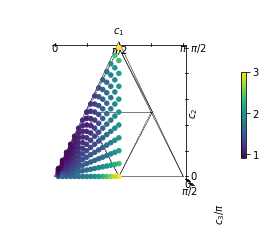

In [8]:
# makes weyl plot of candidate gates with basic metrics
from src.scripts.gate_exploration.bgatev2script import build_gates
from matplotlib import colors
from src.utils.visualize import coordinate_2dlist_weyl
unitary_list, coordinate_list = build_gates()
color_list = []
speed_method = 'linear' 
for u in unitary_list[1:]:
    h = cost_scaling(speed_method=speed_method, duration_1q=0, query_params=u.params)[1][0]
    color_list.append(h)
fig = coordinate_2dlist_weyl(np.array(coordinate_list[1:]).reshape(-1, 3), c=color_list, elev=90, azim=-90, cmap='viridis');
# fig.tight_layout()
#save matplotlib fig as pdf
fig.savefig(f'/home/evm9/decomposition_EM/images/weyl_plot_{speed_method}_haar.pdf', format='pdf')

In [4]:
# atomic function for cost scaling a gate
params = [0,0, 0, np.pi/8, 1]
h = cost_scaling(speed_method='linear', duration_1q=0.1, query_params=params, family_extension=1)[1]
print(h)

In [24]:
from src.utils.custom_gates import ConversionGainGate
params = [0,0, 0, np.pi/8, 1]
basis = ConversionGainGate(*params)
template = MixedOrderBasisCircuitTemplate(base_gates=[basis], chatty_build=False, use_smush_polytope=0)
from qiskit.circuit.library import SwapGate
target = SwapGate().to_matrix()
ret = recursive_sibling_check(template, target, cost_1q=0.1)
print(f"Relative cost {ret[1]}")
ret[0].circuit.draw()

Relative cost 6.4


┌─────────────┐┌──────────────────────┐ ┌─────────────┐ »
q_0: ┤ U(P0,P1,P2) ├┤0                     ├─┤ U(P6,P7,P8) ├─»
     ├─────────────┤│  2qgate(0,0,0,π/4,1) │┌┴─────────────┴┐»
q_1: ┤ U(P3,P4,P5) ├┤1                     ├┤ U(P9,P10,P11) ├»
     └─────────────┘└──────────────────────┘└───────────────┘»
«     ┌──────────────────────┐┌────────────────┐┌──────────────────────┐»
«q_0: ┤0                     ├┤ U(P12,P13,P14) ├┤0                     ├»
«     │  2qgate(0,0,0,π/4,1) │├────────────────┤│  2qgate(0,0,0,π/4,1) │»
«q_1: ┤1                     ├┤ U(P15,P16,P17) ├┤1                     ├»
«     └──────────────────────┘└────────────────┘└──────────────────────┘»
«     ┌────────────────┐
«q_0: ┤ U(P18,P19,P20) ├
«     ├────────────────┤
«q_1: ┤ U(P21,P22,P23) ├
«     └────────────────┘

In [46]:
#make a plot that shows E[haar] as a function of nth root of iswap for varying 1Q durations
from src.scripts.gate_exploration.bgatev2script import cost_scaling
gates = unitary_list
import matplotlib.pyplot as plt
#use matplotlib scientific style
with plt.style.context(['science','ieee']):
    plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})
    #create plot
    h2_list = []
    fig, ax = plt.subplots()
    for duration_1q in [0, .1, .25]:
        h_list = []
        x_list = []
        for gate in gates[1:]:
            if gate.params[2] != 0: #only want to keep iswap gates
                continue
            h = cost_scaling(speed_method='linear', duration_1q=duration_1q, query_params=gate.params)[1][0]
            x_list.append(gate.params[3]/(np.pi/2))
            h_list.append(h)

            #tracking bare costs, but only need to do over a single 1Q duration
            if duration_1q == 0:
                h2 = cost_scaling(speed_method='bare', duration_1q=0, query_params=gate.params)[1][0]
                h2_list.append(h2)

        ax.plot(x_list, h_list, label=f"D[1Q]={duration_1q}", marker='o', markersize=3)

    # plot h2 on a second y-axis
    ax2 = ax.twinx()
    ax2.plot(x_list, h2_list, label=r"Gate count ($k$)", marker = 's', markersize=3, color='green')

    #reverse x axis
    ax.set_xlim(ax.get_xlim()[::-1])
    # xaxis
    ax.set_xlabel("Duration Fractional of iSWAP Basis")
    # yaxis
    ax.set_ylabel("Expected Duration of Haar Gate")
    # title
    # ax.set_title(r"$\mathbb{E}$[D[Haar]]" + " vs. " + r"D[$\sqrt[1/x]{\texttt{iSwap}}]$")
    # legend off plot to the right
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.63))
    ax2.legend(loc='center left', bbox_to_anchor=(1.05, 0.8))

    # figure size for column width of IEEE
    fig.set_size_inches(3.5, 2.5)
    # shrink plot to fit legend
    plt.tight_layout()
    plt.show()

# save as png
fig.savefig('/home/evm9/decomposition_EM/images/haar_vs_iswap.png', format='png')
#save matplotlib fig as pdf
fig.savefig(f'/home/evm9/decomposition_EM/images/haar_vs_iswap.pdf', format='pdf')

In [ ]:
# strategy = ['basic_overall', 'weighted_overall', 'weighted_pairwise'][0]
# basic_metric = [0,1,2][0]
# duration_1q = 0
# pm = pass_manager_slam(strategy=strategy, speed_method='linear', duration_1q=duration_1q, basic_metric=basic_metric)
# transp0 = pm.run(qc)

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 1.37973 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 28.55444 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 1851.89342 (ms)
100%|██████████| 176/176 [00:01<00:00, 150.56it/s]
INFO:root:winner: 2QGate(0.00000000, 0.09817477, 1.00000000), scores: [14.13946996 16.         24.        ], cost: 0.0625
INFO:root:scaled scores: 0.8837168724994594, scaled cost: 0.0625
INFO:root:Found winner, begin substitution
INFO:qiskit.transpiler.runningpassmanager:Pass: SpeedGateSubstitute - 108904.94418 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 7615.91625 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.09251 (ms)
INFO:root:
Transpilation Results:
INFO:root:Gate Counts: {'2QGate(0.00000000, 0.09817477, 1.00000000)': 23428, 'u3': 46865}
INFO:root:Longest Path Gate Counts: {'u3': 19365, '2QGate(0.00000000, 0.09817477, 1.00000000)': 19364}
INFO:roo

In [ ]:
# method = ['linear', 'mid', 'squared', 'hardware'][0]
# strategy = ['basic_overall', 'weighted_overall', 'weighted_pairwise'][1]
# pm = pass_manager_slam(strategy=strategy, speed_method=method, duration_1q=duration_1q)
# transp0 = pm.run(qc)

In [ ]:
# method = ['linear', 'mid', 'squared', 'hardware'][0]
# strategy = ['basic_overall', 'weighted_overall', 'weighted_pairwise'][2]
# pm = pass_manager_slam(strategy=strategy, speed_method=method, duration_1q=duration_1q, coupling_map=coupling_map)
# transp0 = pm.run(qc)

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 0.71168 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 6.20270 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 992.90061 (ms)
INFO:root:Iterating over edges, finding winners
100%|██████████| 112/112 [02:07<00:00,  1.14s/it]
INFO:qiskit.transpiler.runningpassmanager:Pass: SpeedGateSubstitute - 127527.39000 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 3865.64803 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.02813 (ms)
INFO:root:
Transpilation Results:
INFO:root:Gate Counts: {'2QGate(0.00000000, 0.09817477, 1.00000000)': 23428, 'u3': 46865}
INFO:root:Longest Path Gate Counts: {'u3': 19365, '2QGate(0.00000000, 0.09817477, 1.00000000)': 19364}
INFO:root:Duration: 1210.25
INFO:qiskit.transpiler.runningpassmanager:Pass: fooAnalysis - 107.57160 (ms)


In [ ]:
# noisy simulation to calculate QV
# use a QV that includes random gates all over weyl chamber

In [ ]:
# can we come up with an analytical/proof relating gates to work for cnot